In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv, norm
import sympy as sy
import pandas as pd
from pathlib import Path

def get_filepath_data_tyler(filename):
    """
    filepath: copied filepath from windows or mac
    returns: filename: a filename string that can be used in any python function
    """
    filename = "/Data/"+filename  
    return filename
def test_import():
    filename = "Data/test_06_engine_noise_talking_angles.csv"
    # filename = "test_06_engine_noise_talking_angles.csv"
    # filename = get_filepath_data_tyler(filename)
    # print("File exists:", filename.exists())
    # print("Is file:", filename.is_file())
    print(filename)
    pd.read_csv(filename)
test_import()

Data/test_06_engine_noise_talking_angles.csv


In [23]:
class KalmanFilter(object):
    def __init__(self,F,Q,H,R,u):
        """
        Initialize the dynamical system models.
        
        Parameters
        ----------
        F : ndarray of shape (n,n)
            The state transition model.
        Q : ndarray of shape (n,n)
            The covariance matrix for the state noise.
        H : ndarray of shape (m,n)
            The observation model.
        R : ndarray of shape (m,m)
            The covariance matrix for observation noise.
        u : ndarray of shape (n,)
            The control vector.
        """
        # inialize everything
        self.F = F
        self.Q = Q
        self.H = H
        self.R = R
        self.u = u
    def import_csv(self,filename):
        """
        filename: Full filepath of the import csv
        """
        df = pd.read_csv(filename,header=None,index_col=None)
        return df.to_numpy()

    def evolve(self,x0,N):
        """
        Compute the first N states and observations generated by the Kalman system.

        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state.
        N : integer
            The number of time steps to evolve.

        Returns
        -------
        states : ndarray of shape (n,N)
            The i-th column gives the i-th state.
        obs : ndarray of shape (m,N)
            The i-th column gives the i-th observation.
        """
        
        # set n and m to be useful
        n = len(x0)
        m = len(self.H)

        # initialize and empty state and obs matrices
        states = np.zeros((n, N))
        obs = np.zeros((m,N))

        # do the first pass
        states[:,0] = x0
        obs[:,0] = (self.H @ x0 + np.random.multivariate_normal(mean=np.zeros(m), cov=self.R)) % (2*np.pi)

        for i in range(N-1):
            # iterate 
            states[:,i+1] = (self.F @ states[:,i] + self.u + np.random.multivariate_normal(mean=np.zeros(n), cov=self.Q)) % (2*np.pi)
            obs[:,i] = (self.H @ states[:,i] + np.random.multivariate_normal(mean=np.zeros(m), cov=self.R)) % (2*np.pi)

        # do the last one
        obs[:,-1] = (self.H @ states[:,-1] + np.random.multivariate_normal(mean=np.zeros(m), cov=self.R)) % (2*np.pi)

        # return the states and obs
        return states, obs
    

    def estimate(self,x0,P0,z, return_norms = False, circular=True):
        """
        Compute the state estimates using the kalman filter.

        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state estimate.
        P0 : ndarray of shape (n,n)
            The initial error covariance matrix.
        z : ndarray of shape(m,N)
            Sequence of N observations (each column is an observation).

        Returns
        -------
        out : ndarray of shape (n,N)
            Sequence of state estimates (each column is an estimate).
        """
        # get the N, n and initalize an out
        n = len(x0)
        N = z.shape[1]
        out = np.zeros((n, N))

        # set the first value
        out[:,0] = x0

        # iterate 
        for i in range(1,N):
            # we get the temp  by subtracting the observation from the predicted obs
            temp = (z[:,i] - (self.H @ out[:,i-1])) 
            
            # update
            # now yk is either what it is or we shift on the circle no we multiply by the sign to get negatives that are needed
            if circular:
                y = []
                for t in temp: # go through all the angles TODO make this nicer
                    if np.abs(t) > np.pi and t < 0: # first we see if the |angle| is bigger than pi and negative then we shift it back 2pi
                        t += 2*np.pi
                    elif np.abs(t) > np.pi and t > 0: # now we see if the angle is positive to shift it forward 2pi
                        t -= 2*np.pi
                    y.append(t)
                # now save it in the array
                yk = np.array(y)
                # yk = np.minimum(np.abs(temp), 2*np.pi - np.abs(temp)) * np.sign(temp)


            else:
                yk = temp
            Sk = self.H @ P0 @ self.H.T + self.R
            Kk = P0 @ self.H.T @ inv(Sk)
            
            
            xk = (out[:,i-1] + Kk @ yk) # % (2*np.pi)
            Pk = ((np.eye(n) - Kk @ self.H) @ P0).copy()

            # predict
            out[:,i] = (self.F @ xk + self.u) % (2*np.pi)
            P0 = self.F @ Pk @ self.F.T + self.Q
        
        # return out
        return out
    
    def predict(self,x,k):
        """
        Predict the next k states in the absence of observations.

        Parameters
        ----------
        x : ndarray of shape (n,)
            The current state estimate.
        k : integer
            The number of states to predict.

        Returns
        -------
        out : ndarray of shape (n,k)
            The next k predicted states.
        """
        # get the n and initialize and out
        n = len(x)
        out =  np.zeros((n,k))

        # set the first value
        out[:,0] = x
        for i in range(1, k):
            # iterate through 
            out[:,i] = self.F @ out[:,i-1] + self.u

        # return out
        return out
    
    def rewind(self,x,k):
        """
        Predict the states from time 0 through k-1 in the absence of observations.
    
        Parameters
        ----------
        x : ndarray of shape (n,)
            The state estimate at time k.
        k : integer
            The current time step.
    
        Returns
        -------
        out : ndarray of shape (n,k)
            The predicted states from time 0 up through k-1 (in that order).
        """
        # get the n and make an empty out
        n = len(x)
        out =  np.zeros((n,k))

        # do the last one
        out[:,-1] = x

        # save F inverse so we don't compute it everytime
        F_inv = inv(self.F)
        for i in range(1, k):
            # iterate backwards
            out[:,-i-1] = F_inv @ (out[:,-i] - self.u)

        # return out
        return out
         

(18, 100)


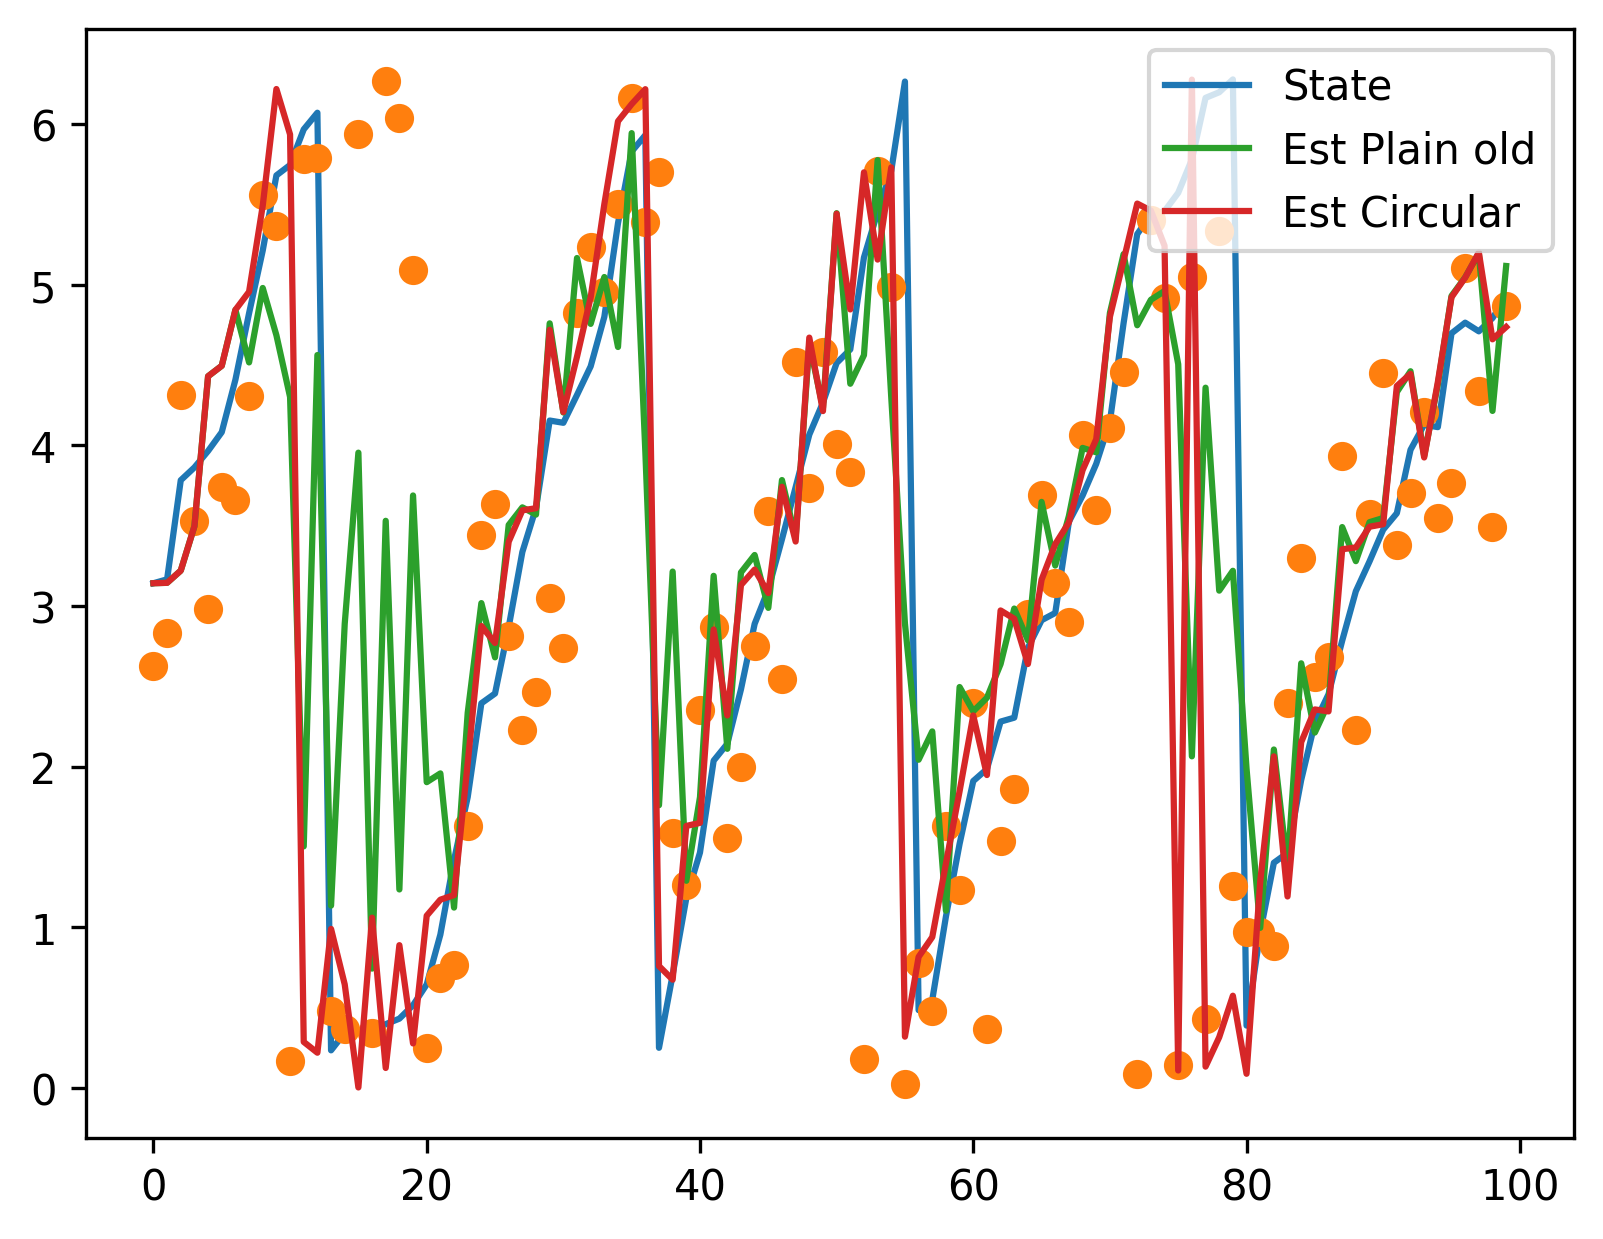

In [24]:
deltat = 0.1
F = np.array([[1,0,deltat],
              [1,0,0],
              [deltat**-1, deltat**-1, 0]])

H = np.zeros((18,3))
H[:,0] = np.ones(18)

u = np.zeros(3)

Q = np.eye(3) * 0.001
R = np.eye(18) * 0.5 

kf = KalmanFilter(F, Q, H, R, u)

x0 = np.array([np.pi, np.pi, 0])
s, obs = kf.evolve(x0, 100)

print(obs.shape)

est_b = kf.estimate(np.array([np.pi, np.pi, 0]), np.eye(3)*0.001, obs[:,:], circular=False)
est_g = kf.estimate(np.array([np.pi, np.pi, 0]), np.eye(3)*0.001, obs[:,:], circular=True)
t = np.arange(100)
plt.figure(dpi=300)
plt.plot(s[0], label='State')
plt.plot(obs[0], 'o')
plt.plot(est_b[0], label='Est Plain old')
plt.plot(est_g[0], label='Est Circular')
plt.legend()
plt.show()

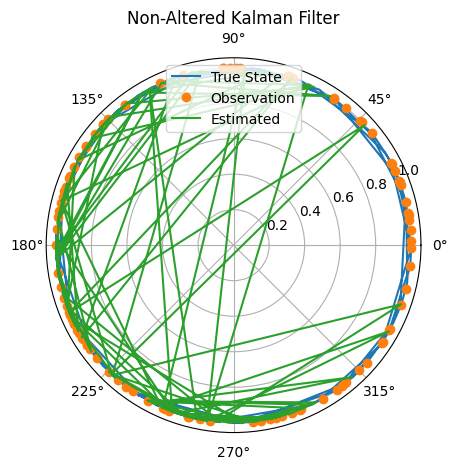

In [25]:
# plt.figure(dpi=300, figsize=(10,5))
plt.polar(s[0], np.ones_like(s[0]), label='True State')
plt.polar(obs[0], np.ones_like(obs[0]), 'o', label='Observation')
# plt.polar(est_g[0], np.ones_like(est_g[0]))
plt.polar(est_b[0], np.ones_like(est_b[0]), label='Estimated')
plt.title('Non-Altered Kalman Filter')
plt.tight_layout()
plt.legend(loc=9)
plt.savefig('non_altered_kalman.pdf')
plt.show()


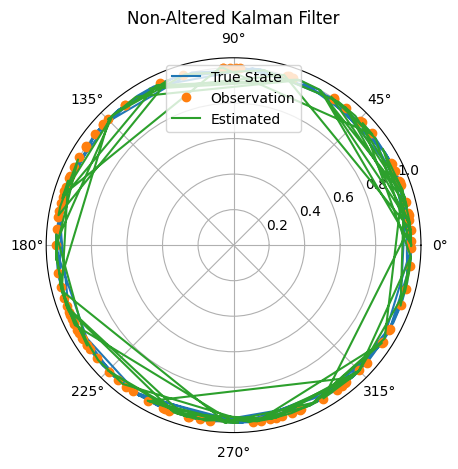

In [26]:
# plt.figure(dpi=300, figsize=(10,5))
plt.polar(s[0], np.ones_like(s[0]), label='True State')
plt.polar(obs[0], np.ones_like(obs[0]), 'o', label='Observation')
plt.polar(est_g[0], np.ones_like(est_g[0]), label='Estimated')
# plt.polar(est_b[0], np.ones_like(est_b[0]), label='Estimated')
plt.title('Non-Altered Kalman Filter')
plt.tight_layout()
plt.legend(loc=9)
plt.savefig('altered_kalman.pdf')
plt.show()

Real Data

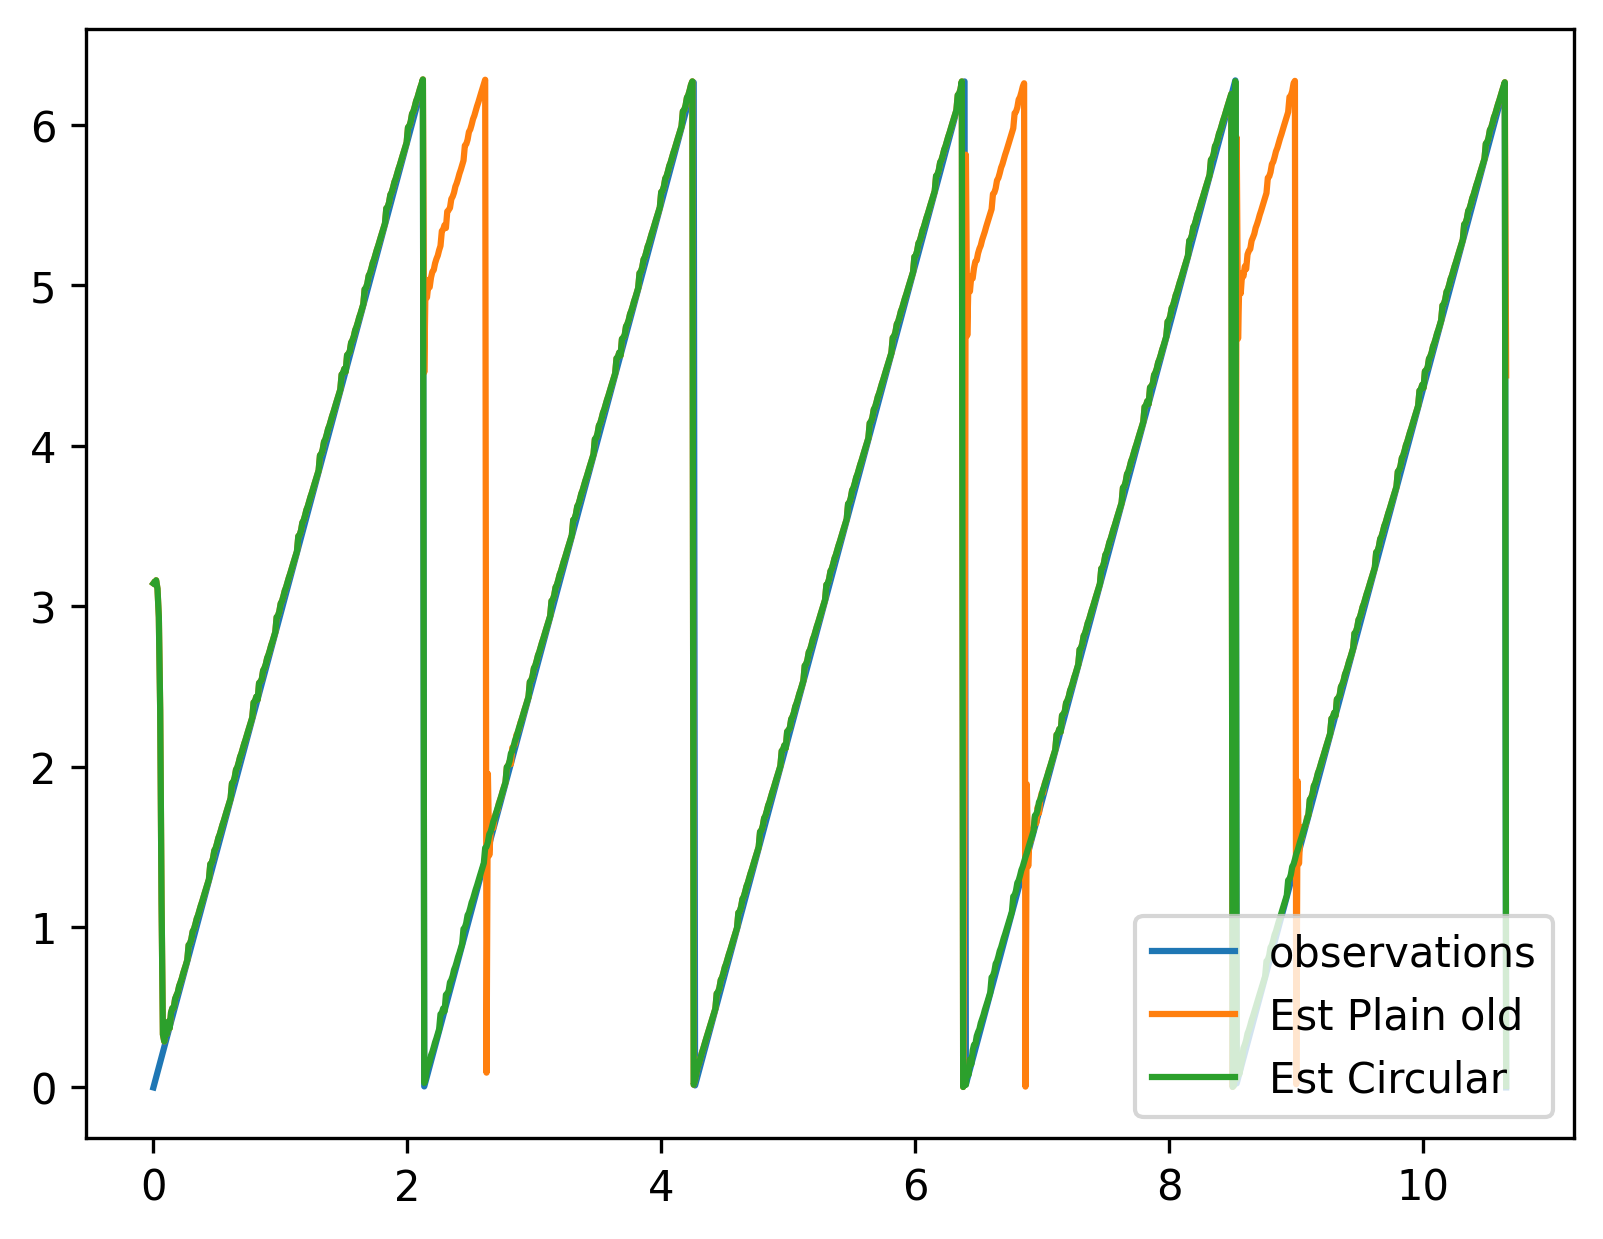

In [27]:
deltat = 512./48000
F = np.array([[1,0,deltat],
              [1,0,0],
              [deltat**-1, deltat**-1, 0]])
#data is just one dimensional theta values
theta_dim = 1
H = np.zeros((theta_dim,3))
H[:,0] = np.ones(theta_dim)
u = np.zeros(3) #No control
Q = np.eye(3) * 0.001
R = np.eye(theta_dim) * 0.5 

kf = KalmanFilter(F, Q, H, R, u)
x0 = np.array([np.pi, np.pi, 0])

#Read in real data
filename = "Data/test_06_engine_noise_talking_angles.csv"
filename = Path(filename)
obs = kf.import_csv(filename)
obs = np.deg2rad(obs)
obs = np.array([np.linspace(0, 10*np.pi, 1000)]) % (2*np.pi)
est_b = kf.estimate(x0, np.eye(3)*0.001, obs, circular=False)
est_g = kf.estimate(x0, np.eye(3)*0.001, obs, circular=True)
t = np.arange(len(obs)/48000)
plt.figure(dpi=300)
t_scale = np.arange(len(est_b[0]))*512./48000 #frame*(512samples/frame)*(1s/48000samples)
plt.plot(t_scale,obs[0], label='observations')
plt.plot(t_scale,est_b[0], label='Est Plain old')
plt.plot(t_scale,est_g[0], label='Est Circular')
plt.legend()
plt.show()